# 1.Setup

In [1]:
from pylab import *
%matplotlib inline
import sys
import caffe
import os
import PIL
import scipy.io as sio
import tempfile

In [2]:
import surgery, score
import os
import setproctitle
setproctitle.setproctitle(os.path.basename(os.getcwd()))

In [3]:
nyud_root = '/home/yongyang/CVProjects/nyud'

# 2.Load AlexNet and modify it to adjust the image size.

In [4]:
from caffe import layers as L
from caffe import params as P

weight_param = dict(lr_mult=1, decay_mult=1)
bias_param   = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]

frozen_param = [dict(lr_mult=0)] * 2

def conv_relu(bottom, ks,nout, stride=1, pad=0, group=1,
              param=learned_param,
              weight_filler=dict(type='xavier'),
              bias_filler=dict(type='constant', value=0.1)):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         param=param, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='xavier', std=0.005),
            bias_filler=dict(type='constant', value=0.1)):
    fc = L.InnerProduct(bottom, num_output=nout, param=param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks=2, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

In [5]:
def alex_net(split, tops,is_train = True, num_classes = 14,classifier_name = 'scene_classifier'):
#     """Returns a NetSpec specifying CaffeNet, following the original proto text
#      specification (./models/bvlc_reference_caffenet/train_val.prototxt)."""    
    n = caffe.NetSpec()
    n.color,n.hha,n.label = L.Python(module='nyud_layers',
            layer='NYUDSegDataLayer', ntop=3,
            param_str=str(dict(nyud_dir=nyud_root+'/data_nyud', split=split,
                tops=tops, seed=1337)))
    n.data = L.Concat(n.color,n.hha)
    
    param = frozen_param
    n.conv1_bgrd, n.relu1 = conv_relu(n.data, 11, 96, stride=4, param=learned_param)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2, param=param)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1, param=param)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2, param=param)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2, param=param)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6_new, n.relu6 = fc_relu(n.pool5, 4096, param=learned_param)
    if is_train: # train phase need dropout layer 
        n.drop6 = fc7input = L.Dropout(n.relu6, in_place=True)
    else:     # test phase no dropout
        fc7input = n.relu6
    n.fc7_new, n.relu7 = fc_relu(fc7input, 4096, param=learned_param)
    if is_train:
        n.drop7 = fc8input = L.Dropout(n.relu7, in_place=True)
    else:
        fc8input = n.relu7
    # always learn fc8 (param=learned_param)
    fc8 = L.InnerProduct(fc8input, num_output=num_classes, param=learned_param)
    # give fc8 the name specified by argument `classifier_name`
    n.__setattr__(classifier_name, fc8)
    if not is_train:
        n.probs = L.Softmax(fc8)
    if n.label is not None:
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)
    return n.to_proto()

with open('alex_train.prototxt', 'w') as f:
    f.write(str(alex_net('train', ['color','hha','sceneLabel'])))
with open('alex_val.prototxt', 'w') as f:
    f.write(str(alex_net('val', ['color','hha','sceneLabel'],is_train = False)))
with open('alex_test.prototxt', 'w') as f:
    f.write(str(alex_net('test', ['color','hha','sceneLabel'],is_train = False)))

In [6]:
caffe.set_mode_cpu()
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.SGDSolver('solver.prototxt')

In [7]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('color', (1, 3, 425, 560)),
 ('hha', (1, 3, 425, 560)),
 ('label', (1, 1)),
 ('label_color_2_split_0', (1, 1)),
 ('label_color_2_split_1', (1, 1)),
 ('data', (1, 6, 425, 560)),
 ('conv1_bgrd', (1, 96, 104, 138)),
 ('pool1', (1, 96, 52, 69)),
 ('norm1', (1, 96, 52, 69)),
 ('conv2', (1, 256, 52, 69)),
 ('pool2', (1, 256, 26, 34)),
 ('norm2', (1, 256, 26, 34)),
 ('conv3', (1, 384, 26, 34)),
 ('conv4', (1, 384, 26, 34)),
 ('conv5', (1, 256, 26, 34)),
 ('pool5', (1, 256, 13, 17)),
 ('fc6_new', (1, 4096)),
 ('fc7_new', (1, 4096)),
 ('scene_classifier', (1, 14)),
 ('scene_classifier_scene_classifier_0_split_0', (1, 14)),
 ('scene_classifier_scene_classifier_0_split_1', (1, 14)),
 ('loss', ()),
 ('acc', ())]

In [8]:
print 'train',solver.net.forward()  # train net
print 'val',solver.test_nets[0].forward()  # test net (there can be more than one)
print 'test',solver.test_nets[1].forward()  # test net (there can be more than one)

train {'acc': array(0.0, dtype=float32), 'loss': array(3.295836925506592, dtype=float32)}
val {'acc': array(0.0, dtype=float32), 'loss': array(3.295836925506592, dtype=float32), 'probs': array([[ 0.03703704,  0.03703704,  0.03703704,  0.03703704,  0.03703704,
         0.03703704,  0.03703704,  0.03703704,  0.03703704,  0.03703704,
         0.03703704,  0.03703704,  0.03703704,  0.03703704,  0.03703704,
         0.03703704,  0.03703704,  0.03703704,  0.03703704,  0.03703704,
         0.03703704,  0.03703704,  0.03703704,  0.03703704,  0.03703704,
         0.03703704,  0.03703704]], dtype=float32)}
test {'acc': array(0.0, dtype=float32), 'loss': array(3.295836925506592, dtype=float32), 'probs': array([[ 0.03703704,  0.03703704,  0.03703704,  0.03703704,  0.03703704,
         0.03703704,  0.03703704,  0.03703704,  0.03703704,  0.03703704,
         0.03703704,  0.03703704,  0.03703704,  0.03703704,  0.03703704,
         0.03703704,  0.03703704,  0.03703704,  0.03703704,  0.03703704,
      

# 3. Visualize the data

In [8]:
def deprocess_net_image(image):
    print image.shape
    image = image[0:3,:,:]            # not include depth channel
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

In [10]:
allSceneLabel =sio.loadmat('/home/yongyang/CVProjects/nyud/data/sceneLabel/imgAllScene.mat')

In [59]:
allSceneLabel.keys()

['sceneName', '__version__', 'gtScene', '__header__', '__globals__']

(6, 425, 560)
The scenery is  kitchen


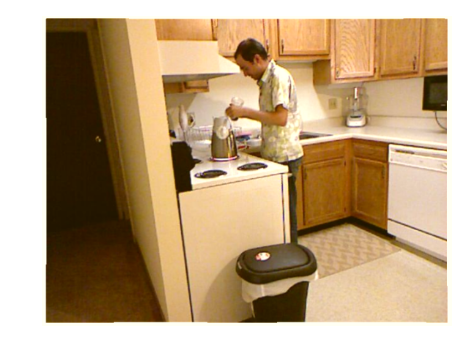

In [60]:
# Show the image here 
imshow(deprocess_net_image(solver.net.blobs['data'].data[0])); axis('off')
index = int(solver.net.blobs['label'].data[0])
print 'The scenery is ',allSceneLabel['sceneName'][0][index-1][0]

In [ ]:
solver.test_nets[0].forward()
imshow(deprocess_net_image(solver.test_nets[0].blobs['data'].data[0]));axis('off')
index = int(solver.test_nets[0].blobs['label'].data[0])
print 'The scenery is ',allSceneLabel['sceneName'][0][index-1][0]

In [ ]:
solver.test_nets[1].forward()
imshow(deprocess_net_image(solver.test_nets[1].blobs['data'].data[0]));axis('off')
index = int(solver.test_nets[1].blobs['label'].data[0])
print 'The scenery is ',allSceneLabel['sceneName'][0][index-1][0]

# 4. Training phase

def run_solver(niter,solver,disp_interval=20, test_interval = 100):
    """Run solver for niter iterations,returning loss and accuracy
    """
    loss = np.zeros(niter)
    val_acc = zeros(int(np.ceil(niter / test_interval)))
    for it in xrange(niter):
        solver.step(1)
        loss[it] = solver.net.blobs['loss'].data.copy()
        if it % disp_interval== 0 or it+1==niter:
            if it!=0:loss_aver = loss[it-9:it+1].mean()
            else:loss_aver = loss[it]
            print 'iter %d loss is %f'%(it,loss_aver)
            
    if it % test_interval== 0 and it != 0:
        correct = 0.
        for i in range(100): # the number in validation is 414
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['probs'].data.argmax(1)
                   == solver.test_nets[0].blobs['label'].data)
        val_acc[it//test_interval] = correct/100.
        print correct
        print 'accuracy is %f'% val_acc[it//test_interval]
    return loss,val_acc

In [9]:
def run_solver(niter,solver,disp_interval=20,test_interval = 200):
    """Run solver for niter iterations,returning loss and accuracy
    """
    loss = np.zeros(niter)
    train_acc_list = np.zeros(niter//test_interval+1)
    val_acc_list = np.zeros(niter//test_interval+1)
    for it in xrange(niter):
         # test phase
        if it%test_interval==0:            
            train_correct = 0 
            for i in range(500): # the number in train test is 364
                solver.net.forward()
                train_correct += sum(solver.net.blobs['scene_classifier'].data.argmax(1)
                       == solver.net.blobs['label'].data)
            train_acc = train_correct/500.
            train_acc_list[it//test_interval] = train_acc
            print 'number correct:',train_correct
            print 'train accuracy is %f'% train_acc  

            # validation phase
            correct = 0.
            for i in range(609): # the number in validation is 609
                solver.test_nets[0].forward()
                correct += sum(solver.test_nets[0].blobs['probs'].data.argmax(1)
                       == solver.test_nets[0].blobs['label'].data)
            val_acc = correct/609.
            val_acc_list[it//test_interval] = val_acc
            print 'number correct:',correct
            print 'validation accuracy is %f'% val_acc

            #if it>600:solver.snapshot()  # store training model
            
            if it//test_interval>0 and val_acc+0.03 < val_acc_list[it/test_interval-1]:break
        # training phase
        solver.step(1)
        loss[it] = solver.net.blobs['loss'].data.copy()
        if it % disp_interval== 0 :
            print 'iter %d loss is %f'%(it,loss[it])
       
                
    return loss,train_acc_list,val_acc_list

In [10]:
from caffe.proto import caffe_pb2
from google.protobuf import text_format
solver_config = caffe_pb2.SolverParameter()
with open('solver.prototxt') as f:
    text_format.Merge(str(f.read()), solver_config)

# SGD solver 
# Modify solver parameters here
solver_config.base_lr = 1e-5
solver_config.weight_decay = 1e-3
solver_config.iter_size = 20
solver_config.lr_policy = 'step'
solver_config.gamma = 0.1
solver_config.stepsize = 4000
# write to file
new_solver_config = text_format.MessageToString(solver_config)
with open('temp.prototxt', 'w') as f:
    f.write(new_solver_config) 
    
caffe.set_mode_cpu()
solver = caffe.SGDSolver('temp.prototxt')

## AdaDelta solver

# Modify solver parameters here
solver_config.base_lr = 1.
solver_config.weight_decay = 0.5
solver_config.iter_size = 20
solver_config.lr_policy = 'fixed'
solver_config.momentum = 0.95
solver_config.delta = 1e-6
solver_config.type = 'AdaDelta'

# write to file
new_solver_config = text_format.MessageToString(solver_config)
with open('temp_adaDelta.prototxt', 'w') as f:
    f.write(new_solver_config) 
    
    
caffe.set_mode_cpu()
solver = caffe.AdaDeltaSolver('temp_adaDelta.prototxt')

## AdaGrad solver

# Modify solver parameters here
solver_config.base_lr = 1.
solver_config.weight_decay = 0.8
solver_config.iter_size = 20
solver_config.lr_policy = 'fixed'

# write to file
new_solver_config = text_format.MessageToString(solver_config)
with open('temp_adaGrad.prototxt', 'w') as f:
    f.write(new_solver_config) 
    
solver = caffe.AdaGradSolver('temp_adaGrad.prototxt')

In [11]:
## Adam solver

# Modify solver parameters here
solver_config.base_lr = 5e-6
solver_config.weight_decay = 0.3
solver_config.iter_size = 20

solver_config.momentum = 0.9
solver_config.momentum2 = 0.999
delta = 1e-8
solver_config.lr_policy = 'fixed'
solver_config.type = 'Adam'
solver_config.snapshot = 200
# write to file
new_solver_config = text_format.MessageToString(solver_config)
with open('temp_adam.prototxt', 'w') as f:
    f.write(new_solver_config) 
    
solver = caffe.AdamSolver('temp_adam.prototxt')

## RMSProp solver

# Modify solver parameters here
solver_config.base_lr = 1.
solver_config.weight_decay = 0.8
solver_config.iter_size = 20

solver_config.momentum = 0.9
solver_config.momentum2 = 0.999
delta = 1e-8
solver_config.lr_policy = 'fixed'


# write to file
new_solver_config = text_format.MessageToString(solver_config)
with open('temp_rmsp.prototxt', 'w') as f:
    f.write(new_solver_config) 
    
solver = caffe.RMSPropSolver('temp_rmsp.prototxt')

In [12]:
# load weight and alex model
weights = '/home/yongyang/CVProjects/nyud/models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
base_net = caffe.Net('/home/yongyang/CVProjects/nyud/models/bvlc_reference_caffenet/deploy.prototxt',weights,
        caffe.TEST)

surgery.transplant(solver.net, base_net)

# surgeries
interp_layers = [k for k in solver.net.params.keys() if 'up' in k]
surgery.interp(solver.net, interp_layers)

solver.net.params['conv1_bgrd'][0].data[:, :3] = base_net.params['conv1'][0].data
solver.net.params['conv1_bgrd'][0].data[:, 3] = np.mean(base_net.params['conv1'][0].data, axis=1)
solver.net.params['conv1_bgrd'][1].data[...] = base_net.params['conv1'][1].data

solver.test_nets[0].share_with(solver.net)
solver.test_nets[1].share_with(solver.net)

dropping conv1
copying conv2  ->  conv2 0
copying conv2  ->  conv2 1
copying conv3  ->  conv3 0
copying conv3  ->  conv3 1
copying conv4  ->  conv4 0
copying conv4  ->  conv4 1
copying conv5  ->  conv5 0
copying conv5  ->  conv5 1
dropping fc6
dropping fc7
dropping fc8


In [13]:
%%time
test_interval = 100
niter = 3001
print 'Running solvers for %d iterations.' % niter
train_loss,train_acc,val_acc = run_solver(niter, solver)
print 'Done.'

Running solvers for 3001 iterations.
number correct: 42
train accuracy is 0.084000
number correct: 52.0
validation accuracy is 0.085386
iter 0 loss is 2.639057
iter 20 loss is 2.479809
iter 40 loss is 2.517794
iter 60 loss is 2.516239
iter 80 loss is 2.968901
iter 100 loss is 2.626507
iter 120 loss is 2.656816
iter 140 loss is 1.875182
iter 160 loss is 2.523155
iter 180 loss is 2.341470
number correct: 100
train accuracy is 0.200000
number correct: 117.0
validation accuracy is 0.192118
iter 200 loss is 2.601730
iter 220 loss is 2.647639
iter 240 loss is 2.397199
iter 260 loss is 2.556798
iter 280 loss is 2.591497
iter 300 loss is 1.684953
iter 320 loss is 2.087144
iter 340 loss is 2.764394
iter 360 loss is 1.603226
iter 380 loss is 2.095089
number correct: 257
train accuracy is 0.514000
number correct: 255.0
validation accuracy is 0.418719
iter 400 loss is 2.286694
iter 420 loss is 1.679269
iter 440 loss is 1.605376
iter 460 loss is 1.834575
iter 480 loss is 2.043953
iter 500 loss is 1

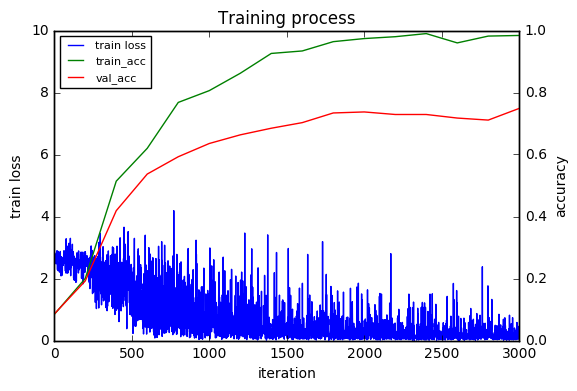

In [16]:
#plot train loss, train accuracy and validation accuracy during the training
niter = 3000
test_interval = 200
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter),train_loss[0:niter],label = 'train loss')
ax1.set_ylim(0,10)
ax2.plot(test_interval* arange(len(train_acc[0:niter/test_interval+1])), train_acc[0:niter/test_interval+1],'-',label='train_acc', color ='g')
ax2.plot(test_interval* arange(len(val_acc[0:niter/test_interval+1])), val_acc[0:niter/test_interval+1],'-',label='val_acc', color='r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('accuracy')

ax1.set_title('Training process')
# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left',prop={'size':8})

# Test phase

In [ ]:
del solver
solver = caffe.AdamSolver('temp_adam.prototxt')
solver.restore('/home/yongyang/CVProjects/nyud/nyud-color-hha/snapshot/train_iter_601.solverstate')
solver.test_nets[0].share_with(solver.net)
solver.test_nets[1].share_with(solver.net)

In [22]:
%%time
niter = 375
output = zeros((niter, 1, 27))
ground_truth = zeros((niter,1,1))
correct = 0 
# the main solver loop
print 'testing...'
for it in range(niter):
    # store the output on the first test batch
    # (start the forward pass at conv1
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
#  how to do it directly in Python, where more complicated things are easi
    
    solver.test_nets[1].forward()
    output[it] = solver.test_nets[1].blobs['probs'].data
    ground_truth[it] = solver.test_nets[1].blobs['label'].data
    correct += sum(solver.test_nets[1].blobs['probs'].data.argmax(1)
                   == solver.test_nets[1].blobs['label'].data)
test_acc = correct / (niter*1.)
print 'num_correct %d'%correct
print 'test accuracy: %f'%test_acc                                                                                                                         

testing...
num_correct 195
test accuracy: 0.520000
CPU times: user 5min 9s, sys: 4.38 s, total: 5min 13s
Wall time: 3min 17s


## Calculate the accuracy for all kinds of scenerys independently

In [23]:
import pandas as pd
tran_txt = pd.read_csv('/home/yongyang/CVProjects/nyud/data/train.txt',header = None)
val_txt = pd.read_csv('/home/yongyang/CVProjects/nyud/data/val.txt',header = None)
test_txt = pd.read_csv('/home/yongyang/CVProjects/nyud/data/test.txt',header = None)

In [24]:
#calculate the classes accuracy
scenes_lists = []
for i in xrange(27):
    scenes_lists.append([])
for i in xrange(ground_truth.shape[0]):
    scenes_lists[int(ground_truth[i][0][0])-1].append(i)
    
result = np.zeros((27,2))
for i in xrange(27):
    num = len(scenes_lists[i])
    accu = nan
    correct = 0.
    if num!=0:
        for j in range(num):
            correct += sum(output[scenes_lists[i][j]].argmax(1) == ground_truth[scenes_lists[i][j]])
        accu = correct/num
    result[i][0] = num
    result[i][1] = accu

In [29]:
# ouput to csv file
result_pd = pd.DataFrame(result)
result_pd['scene_name'] = 'ok'
for i in xrange(27):
    result_pd['scene_name'][i]= allSceneLabel['sceneName'][0][i][0]
result_pd.columns = ['num','accuracy','scene_name']
result_pd = result_pd.set_index('scene_name',drop = True)
result_pd['num'] = result_pd['num'].astype('int')
result_pd.to_csv('test_result.csv')

/home/yongyang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [30]:
print result_pd[0:27]

                 num  accuracy
scene_name                    
basement           2  0.000000
bathroom          31  0.903226
bedroom           96  0.947917
bookstore          9  0.666667
cafe               2  0.000000
classroom         13  0.538462
computer_lab       2  0.000000
conference_room    2  0.000000
dinette            1  0.000000
dining_room       30  0.400000
excercise_room     1  0.000000
foyer              1  0.000000
furniture_store    7  0.714286
home_office       13  0.000000
home_storage       2  0.000000
indoor_balcony     1  0.000000
kitchen           57  0.578947
laundry_room       1  0.000000
living_room       56  0.142857
office            20  0.250000
office_kitchen     3  0.000000
playroom           8  0.000000
printer_room       1  0.000000
reception_room     5  0.000000
student_lounge     2  0.000000
study              7  0.000000
study_room         2  0.000000


(6, 425, 560)
The scenery is  basement
The prediction is:
bedroom :  0.334098
kitchen :  0.0776251
playroom :  0.0556291
office :  0.0525304
classroom :  0.0511925


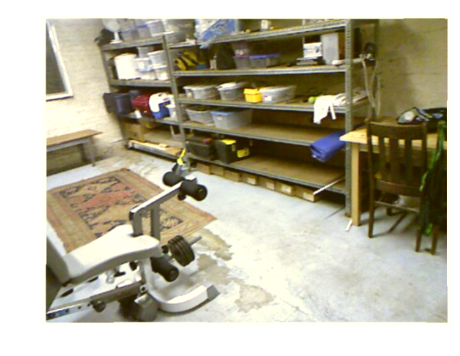

In [25]:
#An example to show the probablity distribution over scenes of a test sample¶
solver.test_nets[1].forward()
imshow(deprocess_net_image(solver.test_nets[1].blobs['data'].data[0]));axis('off')
index = int(solver.test_nets[1].blobs['label'].data[0])
print 'The scenery is ',allSceneLabel['sceneName'][0][index-1][0]

probs = solver.test_nets[1].blobs['probs'].data[0]
predict_index = probs.argmax()
num_tops = 5
highst_indexes = np.array(probs).argsort()[::-1][:num_tops]  # the top 5 probability of scenes
print 'The prediction is:'
for i in highst_indexes:
    print allSceneLabel['sceneName'][0][i-1][0],': ',probs[i]

(6, 425, 560)
The scenery is  bedroom
The prediction is:
bedroom :  0.715758
living_room :  0.0716944
playroom :  0.0435054
office :  0.0190863
office_kitchen :  0.0155353


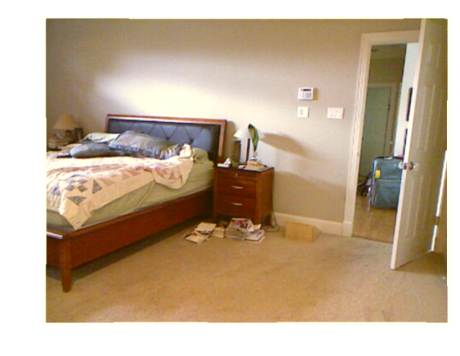

In [41]:
#An example to show the probablity distribution over scenes of a test sample¶
for i in xrange(20):
    solver.test_nets[1].forward()
imshow(deprocess_net_image(solver.test_nets[1].blobs['data'].data[0]));axis('off')
index = int(solver.test_nets[1].blobs['label'].data[0])
print 'The scenery is ',allSceneLabel['sceneName'][0][index-1][0]

probs = solver.test_nets[1].blobs['probs'].data[0]
predict_index = probs.argmax()
num_tops = 5
highst_indexes = np.array(probs).argsort()[::-1][:num_tops]  # the top 5 probability of scenes
print 'The prediction is:'
for i in highst_indexes:
    print allSceneLabel['sceneName'][0][i-1][0],': ',probs[i]

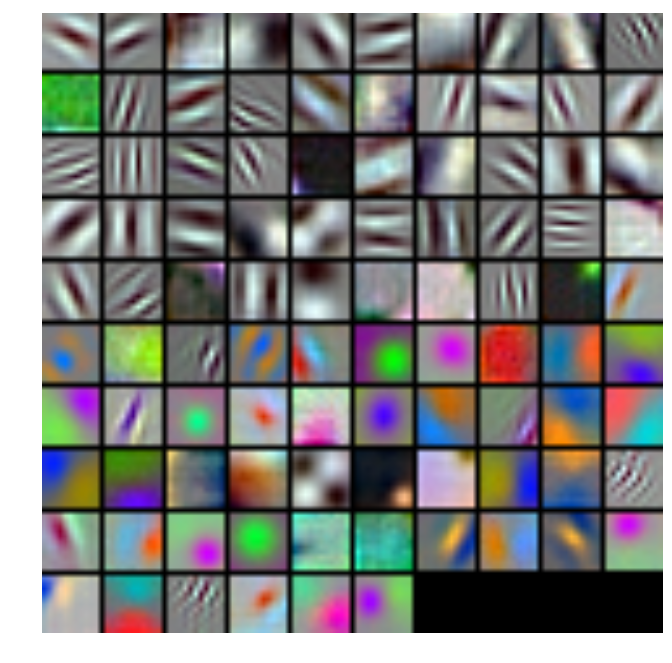

In [42]:
from vis_utils import visualize_grid
import matplotlib.pyplot as plt
grid = visualize_grid(solver.net.params['conv1_bgrd'][0].data[:,0:3,:].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(8, 8)
plt.show()

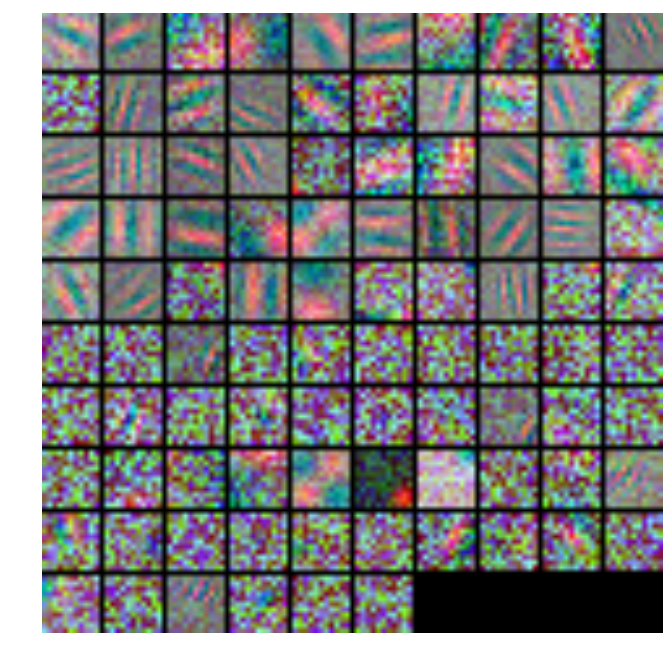

In [43]:
grid = visualize_grid(solver.net.params['conv1_bgrd'][0].data[:,3:6,:].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(8, 8)
plt.show()